Adapted from: https://keras.io/examples/structured_data/collaborative_filtering_movielens/

## Importing Libraries

Once again, we are using keras and tensorflow for the machine learning component of our algorithm. In addition, this week we are also using Pandas to manage databases.

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

## Importing and transforming the data

Like in previous weeks, the first step is to import our dataset of movie recommendations to Google Colab and extract the ZIP file. This week you do not need to download it from Canvas, since the dataset is hosted online. If you copy the URL (http://files.grouplens.org/datasets/movielens/ml-latest-small.zip) to your browser, you can also inspect the recommendations dataset yourself.

In [ ]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

991232/978202 [==============================] - 0s 0us/step
Extracting all the files now...
Done!


This bit of code adds a custom user to the dataset that you can use to audit and test the algorith. This will be user number 611. The list of 'movieId' contains the movies that this test user has watched. The "movies.csv" file in the dataset tells you which number corresponds to which movie. Therefore if you want to tell the algorith that the user has watched The Lord of the Rings: The Return of the King (2003), you would add the corresponding number (7153) to the list like this 'movieId': [1, 2, 3, 7153]. You then have to add the corresponding rating (from 0.5 to 5) to the movie (e.g. Lord of the Rings is awesome, so you would add a 5 'rating': [4.5, 4, 5, 5]. The ratings need to be given in the same order as the movies. The timestamp is the date that the user watched the movie, and can be ignored for this recommender system. You can also delete or replace the existing movies if you want (i.e. 1,2,3).

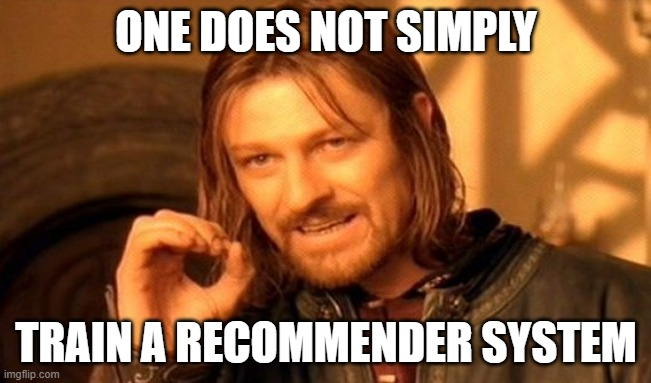

In [ ]:
test_user = pd.DataFrame({
    'userId': 611, 
    'movieId': [1, 2, 3], 
    'rating': [4.5, 4, 5],
    'timestamp': 964982931})

df = df.append(test_user, ignore_index=True)

You will notice that the dataset is comprised of multiple CSV files, this bit of code 'combines' them and makes sure that every data feature is converted to a number, so that it can be processed by the neural network.

In [ ]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 611, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


This bit splits the dataset into 90% training and 10% validation.

In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

## Creating and training the neural network

This step defines the neural network architecture, in this case we are using Keras' RecommenderNet. Some key terms here are the EMBEDDING_SIZE (larger size = more complexity, but that is not always the same as more performance) and the bias (roughly equal to how popular is a movie and how avid a consumer is, different from our everyday understanding of bias)

In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

This step trains the model, by now you know how this works :)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/10
1419/1419 [==============================] - 8s 5ms/step - loss: 0.6363 - val_loss: 0.6202
Epoch 2/10
1419/1419 [==============================] - 7s 5ms/step - loss: 0.6135 - val_loss: 0.6168
Epoch 3/10
1419/1419 [==============================] - 6s 5ms/step - loss: 0.6086 - val_loss: 0.6121
Epoch 4/10
1419/1419 [==============================] - 6s 5ms/step - loss: 0.6071 - val_loss: 0.6130
Epoch 5/10
1419/1419 [==============================] - 7s 5ms/step - loss: 0.6075 - val_loss: 0.6120
Epoch 6/10
1419/1419 [==============================] - 6s 5ms/step - loss: 0.6066 - val_loss: 0.6132
Epoch 7/10
1419/1419 [==============================] - 7s 5ms/step - loss: 0.6061 - val_loss: 0.6121
Epoch 8/10
1419/1419 [==============================] - 8s 6ms/step - loss: 0.6051 - val_loss: 0.6132
Epoch 9/10
1419/1419 [==============================] - 7s 5ms/step - loss: 0.6050 - val_loss: 0.6132
Epoch 10/10
1419/1419 [==============================] - 7s 5ms/step - loss: 0.604

This allows you to vizualize the training and validation loss.

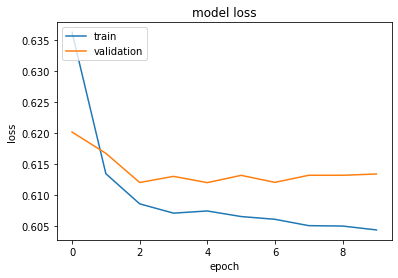

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

This long and seemingly complicated bit of code is simply applying the same transformations of the dataset to user 611 (the one we created earlier) to generate movie recommendations to this user based on their movie history and ratings.

In [ ]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = 611

movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 611
Movies with high ratings from user
--------------------------------
Toy Story (1995) : Adventure|Animation|Children|Comedy|Fantasy
Jumanji (1995) : Adventure|Children|Fantasy
Grumpier Old Men (1995) : Comedy|Romance
--------------------------------
Top 10 movie recommendations
--------------------------------
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Shawshank Redemption, The (1994) : Crime|Drama
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Godfather, The (1972) : Crime|Drama
Doctor Zhivago (1965) : Drama|Romance|War
Life Is Beautiful (La Vita è bella) (1997) : Comedy|Drama|Romance|War
American History X (1998) : Crime|Drama
Monty Python's And Now for Something Completely Different (1971) : Comedy
Lord of the Rings: The Return of the King, The (2003) : Action|Adventure|Drama|Fantasy
Dark Knight, The (2008) : Action|Crime|Drama|IMAX
